In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline

###Q1 Import the dataset and try to understand what information each column is giving. What is our target variable? Is this a classification or regression problem?

Dataset link: https://drive.google.com/file/d/1A-iAsI3MUU6o9oh5AE1NG1kVU5KD60Ms/view?usp=sharing


In [78]:
#Import dataset
df = pd.read_csv("drive/MyDrive/heart_study.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

sex : male or female (Nominal)

age : age of the patient (Continuous)

education: maximum level of education of the patient

currentSmoker : whether or not the patient is a current smoker (Nominal)

cigsPerDay : the number of cigarettes that the person smoked on average in one day (Continuous)

BPMeds : whether or not the patient was on blood pressure medication (Nominal)

prevalentStroke : whether or not the patient had previously had a stroke (Nominal)

prevalentHyp : whether or not the patient was Hypertension (Nominal)

diabetes : whether or not the patient had diabetes (Nominal)

totChol : total cholesterol level (Continuous)

sysBP : systolic blood pressure (Continuous)

diaBP : diastolic blood pressure (Continuous)

BMI : Body Mass Index (Continuous)

heartRate : heart rate (Continuous)

glucose : glucose level (Continuous)

TenYearCHD : 10 year risk of Coronary Heart Disease (CHD) (binary: 1 (Yes), 0 (No))

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

###Q2. Are there any columns which give information about something totally irrelevant to whether a person has a heart disease or not? If yes, drop the column. Also rename the column 'male' to 'sex_male'.

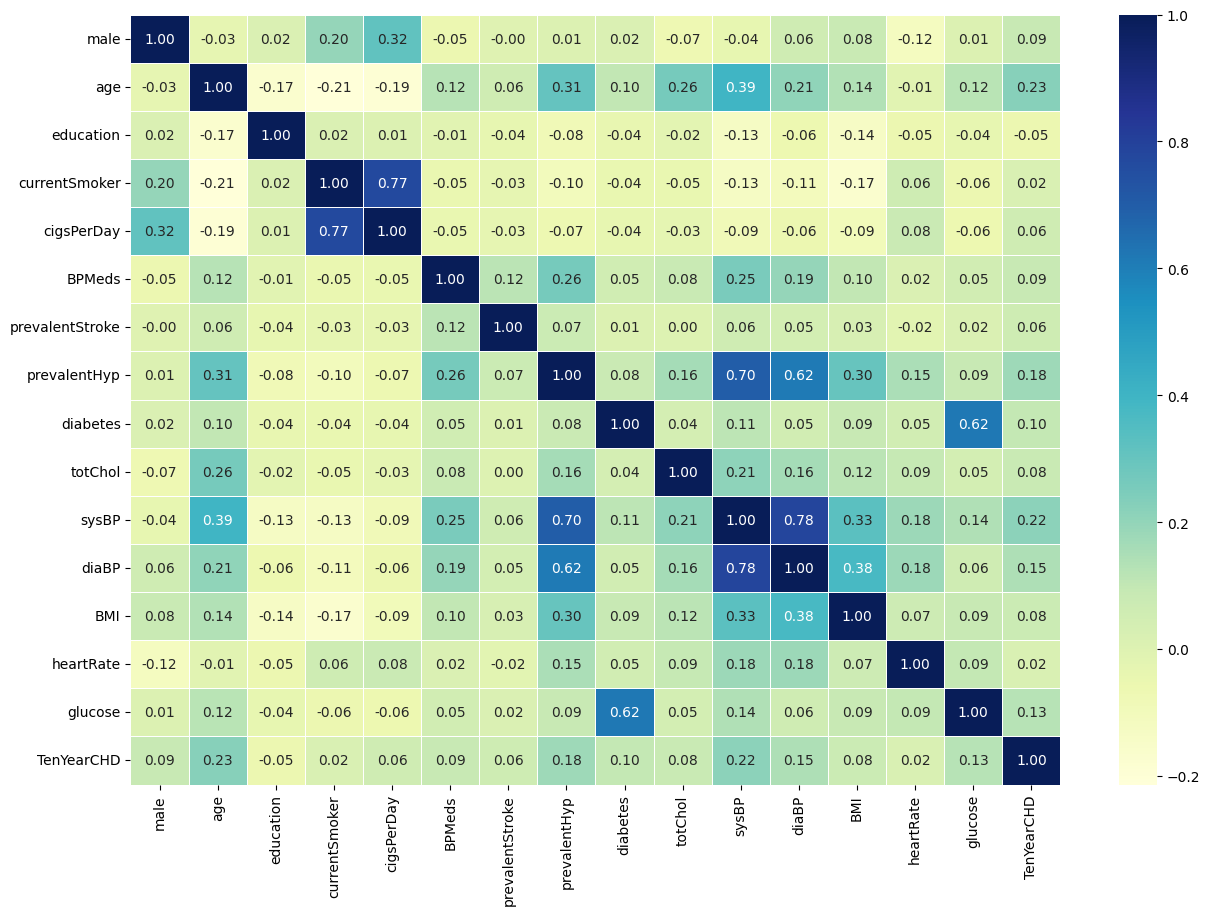

In [ ]:
# in order to find out about the correlations with the target variable, we will plot a heatmap
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");

* from the above correlation heatmap, the currentSmoker and heartRate columns show the least amount of correlation(0.02) with the target variable
* we're deleting the heartRate column and not the currentSmoker column because it will help us in imputing the missing values

In [ ]:
#drop columns
df.drop(['heartRate'], axis=1, inplace=True)

In [ ]:
#rename column
df.rename(columns={'male':'sex_male'}, inplace = True)

In [ ]:
df.head()

,sex_male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,0


###Q3. Find the number of null values in each column and decide whether you can drop them or not. If you cannot drop them, use an appropriate method to deal with them

In [ ]:
df.isnull().sum()

sex_male             0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
glucose            388
TenYearCHD           0
dtype: int64

* education
 * null values in the education column are MCAR and hence they can be deleted.
* cigsPerDay
 * missing values in cigsPerDay is MAR as ALL the people who have missing values in cigsPerDay are active smokers
 * some people might hesitate on giving out the exact number of cigs per day that they smoke
 * cigsPerDay is correlated the most with gender and currentSmoker
 * we will proceed with the multivariate approach using IterativeImputer
* glucose
 * missing data in this column is MCAR
 * hence filling this column using median as the dataset contains certain outliers
* BPmeds
 * it is MCAR
 * 97.035% of the data in this column is 0.0, hence filling the null values with the value 0.0

In [ ]:
# education
df.dropna(subset=['education'], inplace=True)

In [ ]:
# cigsPerDay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
iter_imp = IterativeImputer()

cols = ['cigsPerDay', 'currentSmoker', 'sex_male']
X = df[cols]
result = iter_imp.fit_transform(X)

df['cigsPerDay'] = result[: , cols.index('cigsPerDay')]
df[df['cigsPerDay'].isnull()]

,sex_male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,glucose,TenYearCHD


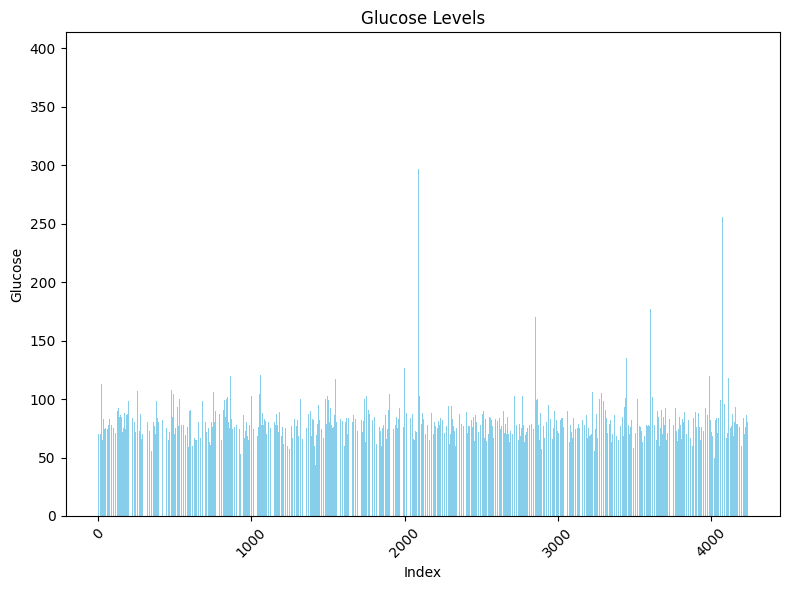

In [ ]:
# glucose
plt.figure(figsize=(8, 6))
plt.bar(df['glucose'].index, df['glucose'], color='skyblue')
plt.xlabel('Index')
plt.ylabel('Glucose')
plt.title('Glucose Levels')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()
plt.show()

df['glucose'] = df['glucose'].fillna(df['glucose'].median())

In [ ]:
# BPMeds
df['BPMeds'] = df['BPMeds'].fillna(0.0)

In [ ]:
# total chol
df['totChol'] = df['totChol'].fillna(df['totChol'].mean())

In [ ]:
# BMI
df['BMI'] = df['BMI'].fillna(df['BMI'].mean())

In [ ]:
df.isnull().sum()

sex_male           0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
glucose            0
TenYearCHD         0
dtype: int64

###Q4. The following code is set up for you, replace 'dataframe' with the name of the your variable. What do you understand from this EDA? Why do some graphs have only two bars, at 0 and 1 and others have multiple?

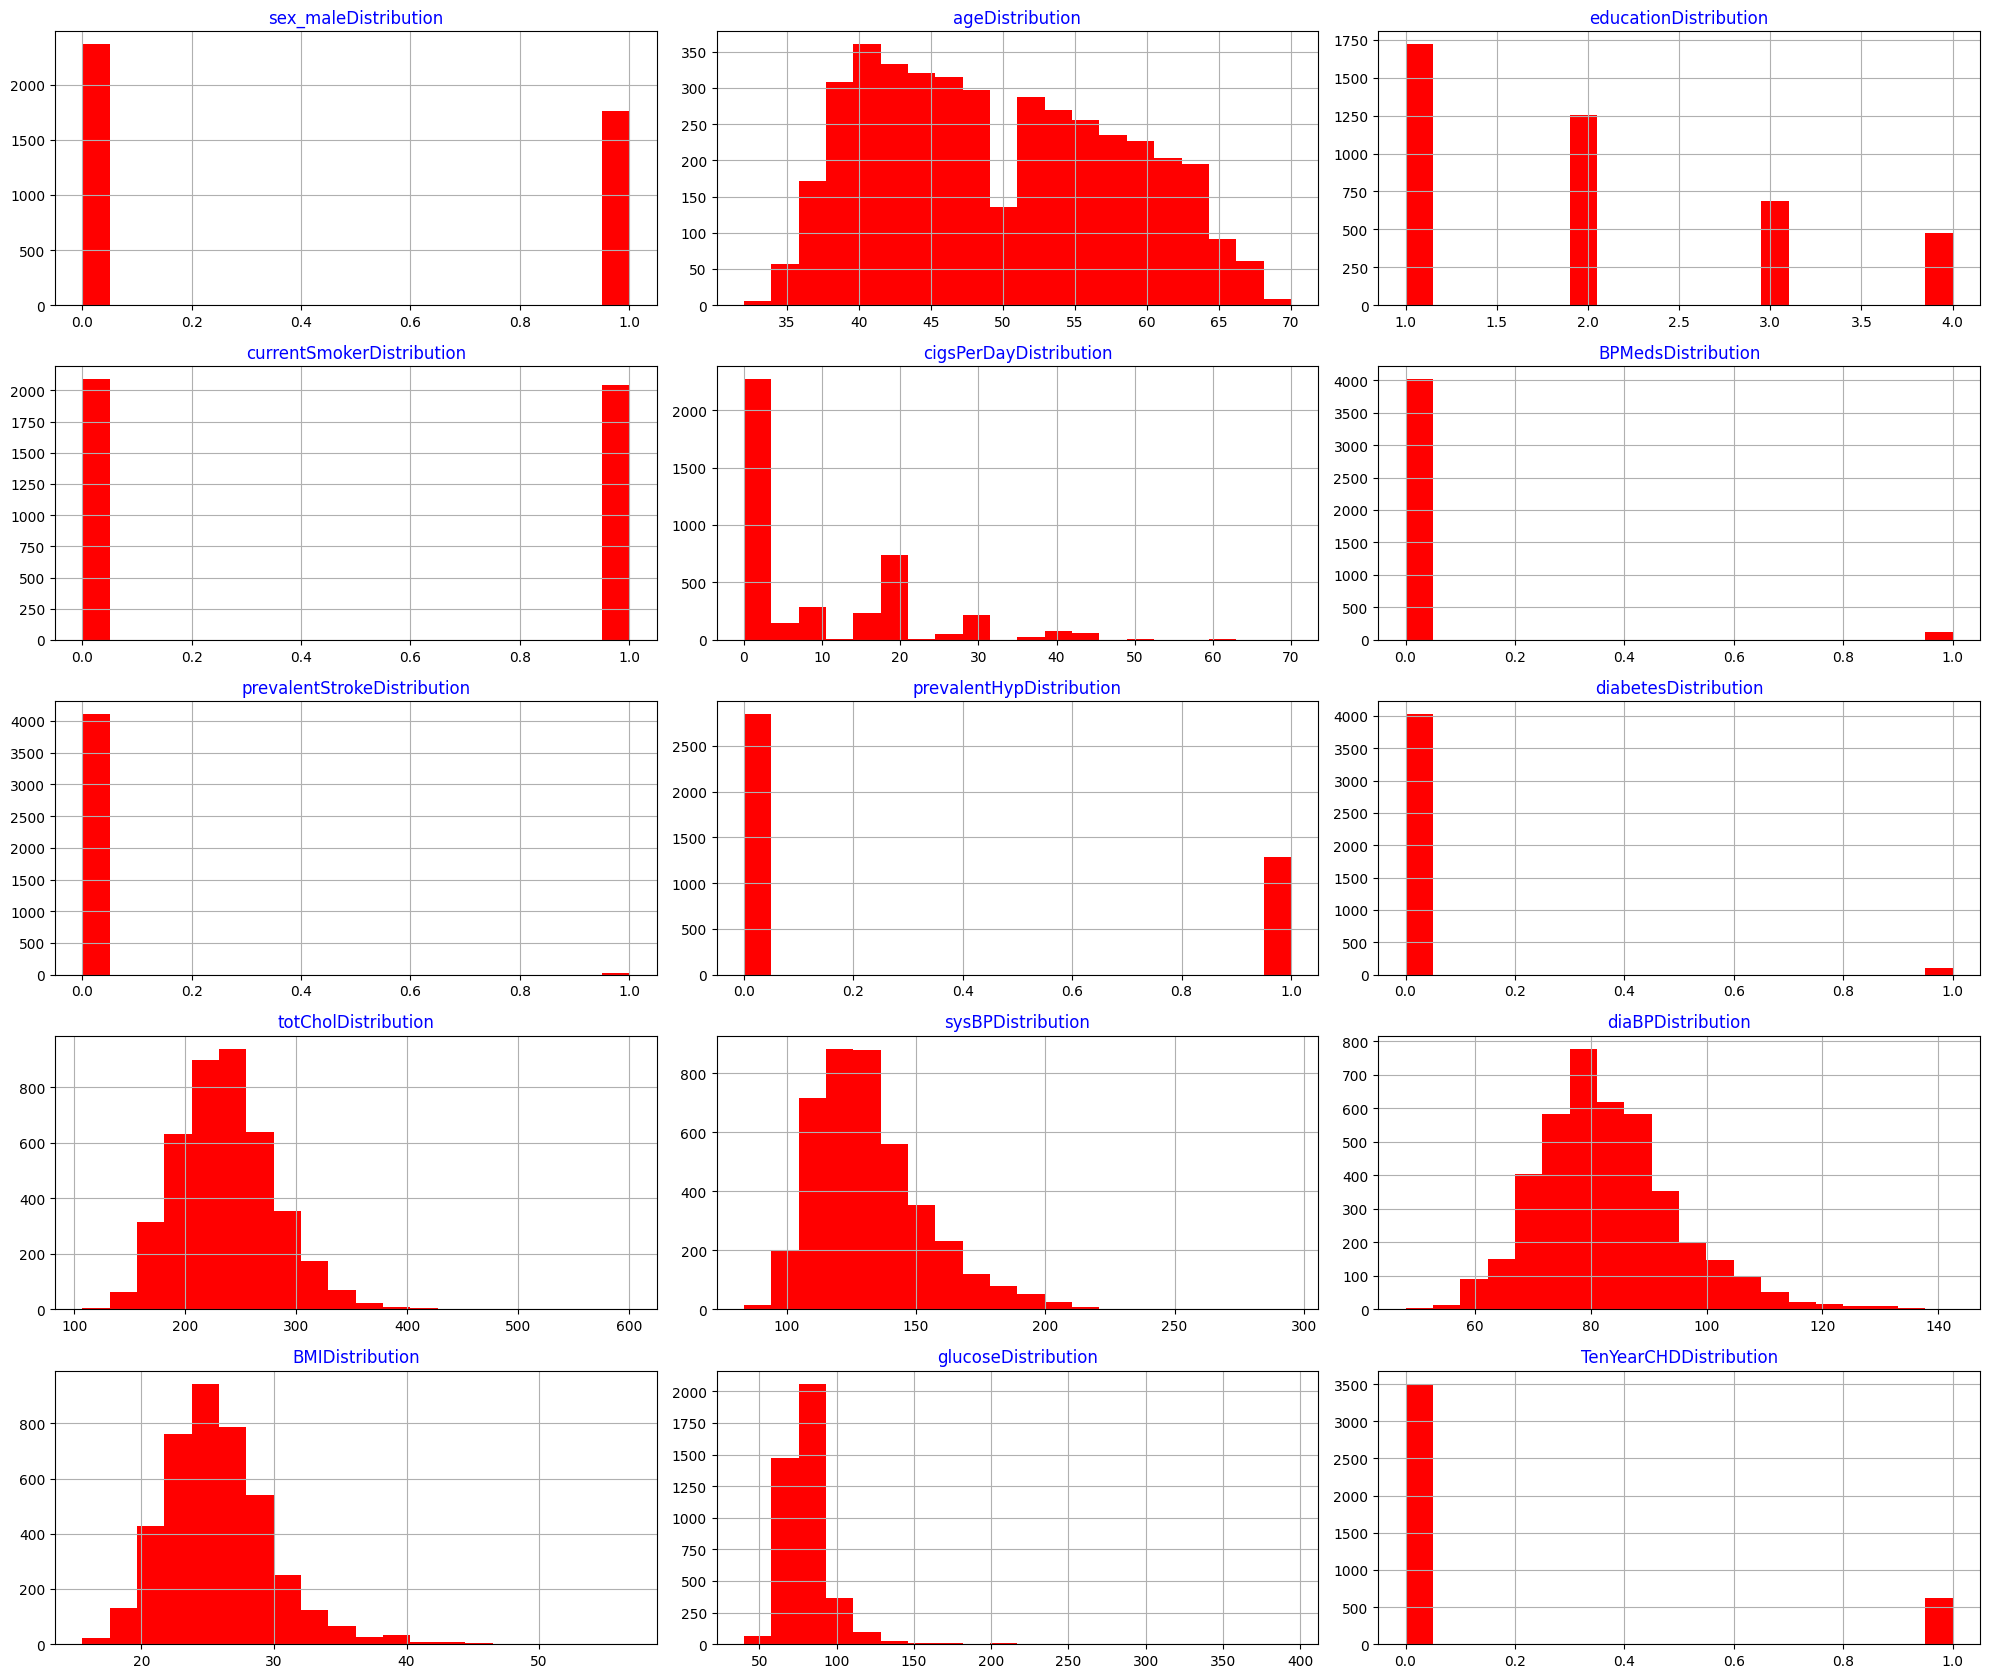

In [ ]:
def draw_histograms(df, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        df[feature].hist(bins=20,ax=ax,facecolor='red')
        ax.set_title(feature+"Distribution", color='blue')
    fig.tight_layout()
    plt.show()
draw_histograms(df, df.columns, 6, 3)

###Q5. Using sns.countplot find out number of Positive cases and Negative cases in the dataset, i.e., in your target column.

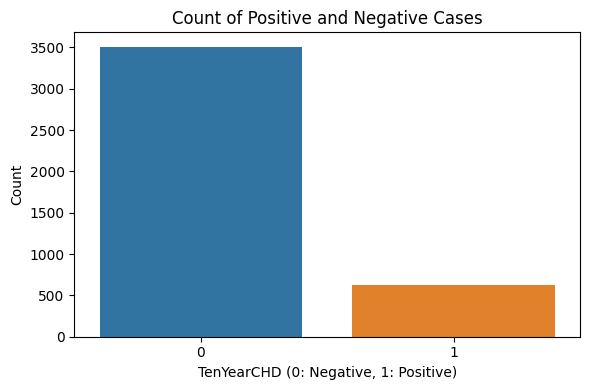

In [ ]:
#Code
plt.figure(figsize=(6, 4))
sns.countplot(df, x='TenYearCHD')
plt.xlabel('TenYearCHD (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.title('Count of Positive and Negative Cases')
plt.tight_layout()

In [ ]:
positive_count = (df['TenYearCHD'] == 1).sum()
negative_count = (df['TenYearCHD'] == 0).sum()
print(f"Positive Cases: {positive_count}")
print(f"Negative Cases: {negative_count}")

Positive Cases: 628
Negative Cases: 3507


###Q6a. Split the dataset into train and test and fit the training dataset in the Logistic Regression.

In [ ]:
#Split the dataset and fit the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
np.random.seed(42)

X = df.drop('TenYearCHD', axis = 1)
y = df['TenYearCHD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression(max_iter = 1500)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
model.score(X_test, y_test)

0.8331318016928658

###Q6b. Does running the above code give a Convergence Warning? What could be the cause of this problem? Try to find out methods that can deal with this problem.

* the issue to the convergence warning can be solved by increasing the maximum number of iterations.

Although there are several methods, we will use backward feature selection to solve this problem. You can learn more about feature selection using the below link.

https://www.javatpoint.com/feature-selection-techniques-in-machine-learning

Understand and run the following 4 cells which carry out backward feature selection for you. Make sure to replace 'df' by your dataframe variable

In [ ]:
from statsmodels.tools import add_constant as add_constant
df_constant = add_constant(df)
df_constant.head()

,const,sex_male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,glucose,TenYearCHD
0,1.0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,77.0,0
1,1.0,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,76.0,0
2,1.0,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,70.0,0
3,1.0,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,103.0,1
4,1.0,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,0


In [ ]:
st.chisqprob = lambda chisq, df: st.chi2.sf(chisq, df)
cols = df_constant.columns[:-1]
model = sm.Logit(df.TenYearCHD, df_constant[cols])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.378504
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4135
Model:                          Logit   Df Residuals:                     4120
Method:                           MLE   Df Model:                           14
Date:                Fri, 01 Dec 2023   Pseudo R-squ.:                  0.1114
Time:                        17:58:10   Log-Likelihood:                -1565.1
converged:                       True   LL-Null:                       -1761.3
Covariance Type:            nonrobust   LLR p-value:                 5.176e-75
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.0964      0.627    -12.911      0.000      -9.325      -6.867
sex_male            0.4924      0.101      4.879      0.000       0.295       0.690
age                 0.0627      0.006      9.964      0.000       0.050       0.075
education          -0.0120      0.046     -0.260      0.795      -0.103       0.079
currentSmoker       0.0087      0.147      0.059      0.953      -0.280       0.297
cigsPerDay          0.0204      0.006      3.489      0.000       0.009       0.032
BPMeds              0.2669      0.222      1.205      0.228      -0.167       0.701
prevalentStroke     0.9536      0.441      2.161      0.031       0.089       1.818
prevalentHyp        0.2413      0.130      1.857      0.063      -0.013       0.496
diabetes            0.2342      0.297      0.789      0.430      -0.347       0.816
totChol             0.0018      0.001      1.694      0.090      -0.000       0.004
sysBP               0.0143      0.004      4.006      0.000       0.007       0.021
diaBP              -0.0037      0.006     -0.613      0.540      -0.016       0.008
BMI                 0.0013      0.012      0.106      0.916      -0.022       0.025
glucose             0.0061      0.002      2.857      0.004       0.002       0.010
===================================================================================
"""

In [ ]:
def back_feature_elem (data_frame, dep_var, col_list):
    while len(col_list)>0 :
        model = sm.Logit(dep_var,data_frame[col_list])
        result = model.fit(disp=0)
        largest_pvalue = round(result.pvalues,3).nlargest(1)
        if largest_pvalue[0]<(0.05):
            return result
            break
        else:
            col_list = col_list.drop(largest_pvalue.index)
result = back_feature_elem(df_constant, df.TenYearCHD, cols)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4135
Model:                          Logit   Df Residuals:                     4128
Method:                           MLE   Df Model:                            6
Date:                Fri, 01 Dec 2023   Pseudo R-squ.:                  0.1087
Time:                        17:58:11   Log-Likelihood:                -1569.8
converged:                       True   LL-Null:                       -1761.3
Covariance Type:            nonrobust   LLR p-value:                 1.216e-79
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.4613      0.394    -21.497      0.000      -9.233      -7.690
sex_male            0.4639      0.098      4.710      0.000       0.271       0.657
age                 0.0655      0.006     10.898      0.000       0.054       0.077
cigsPerDay          0.0207      0.004      5.290      0.000       0.013       0.028
prevalentStroke     1.0358      0.436      2.374      0.018       0.181       1.891
sysBP               0.0171      0.002      8.471      0.000       0.013       0.021
glucose             0.0073      0.002      4.422      0.000       0.004       0.010
===================================================================================
"""

In [ ]:
params = np.exp(result.params)
conf = np.exp(result.conf_int())
conf['OR'] = params
pvalue = round(result.pvalues,3)
conf['pvalue'] = pvalue
conf.columns = ['CI 95%(2.5%)','CI 95%(97.5%)', 'Odds Ratio', 'pvalue']
print((conf))

                 CI 95%(2.5%)  CI 95%(97.5%)  Odds Ratio  pvalue
const                0.000098       0.000457    0.000211   0.000
sex_male             1.311123       1.928953    1.590312   0.000
age                  1.055164       1.080308    1.067662   0.000
cigsPerDay           1.013130       1.028807    1.020938   0.000
prevalentStroke      1.198187       6.625024    2.817448   0.018
sysBP                1.013233       1.021284    1.017250   0.000
glucose              1.004058       1.010553    1.007300   0.000


###Q7. The above table mentions the columns with the highest importance. Create a new dataframe with just these columns and your target column. Split it into training and testing dataset and fit the training data into Logistic regression model. Also predict the y values for the test set.

In [ ]:
#Split the new dataset and fit the model
model = LogisticRegression(max_iter = 2000)

cols = ['sex_male','cigsPerDay','age','prevalentStroke','sysBP','glucose','TenYearCHD']
df_new = df[cols]

X_new = df_new.drop('TenYearCHD', axis = 1)
y_new = df_new['TenYearCHD']

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.2)

model.fit(X_train, y_train)
y_preds = model.predict(X_test)
model.score(X_test, y_test)

0.8512696493349455

In [ ]:
y_preds[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

###Q8a. Create a confusion matrix for y test and y predcted values. Since this is prediction of heart disease which metric should be given more importance - Precision or Recall? Justify.

In [ ]:
#Code for confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_preds)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[693   1]
 [122  11]]


* precision is given by the formula `(TP / (TP + FP))`
* recall is given by the formula `(TP / (TP + FN))`
* High precision is vital when the cost of false positives is high. In heart disease prediction, a false positive (indicating a person has heart disease when they don't) might lead to unnecessary treatments or stress for the individual.
* High recall is important when the cost of false negatives is high. In heart disease prediction, a false negative (missing an actual heart disease case) could be life-threatening if the individual doesn't receive necessary medical attention.
* in the context of heart disease, `recall` will be given more importance as missing an actual heart disease case if much more harmful and dangerous.

###Q8b. Using the above confusion matrix, how would you find out Accuracy, Precision and Recall values. Calculate them using the formulae which takes into account True Positive, False Positive, True Negative and False Negative values.

In [ ]:
TN, FP, FN, TP = conf_matrix.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)

precision = TP / (TP + FP)

recall = TP / (TP + FN)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8513
Precision: 0.9167
Recall: 0.0827
